     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.5 MB/s eta 0:00:00
--- Circuit Diagrams (Matplotlib Visualization) ---

1. Deutsch-Jozsa Circuit (Sequential):


/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:270: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(


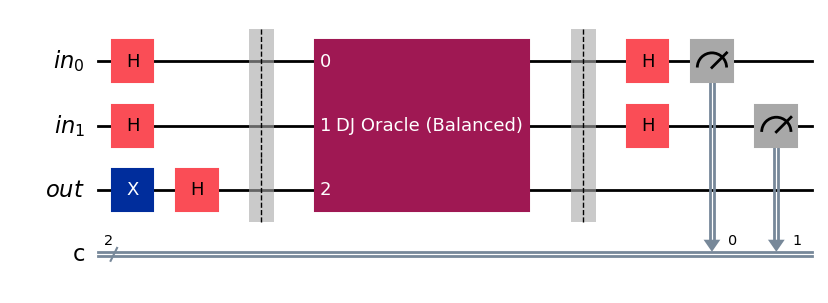


2. Simon's Algorithm Circuit (Sequential):


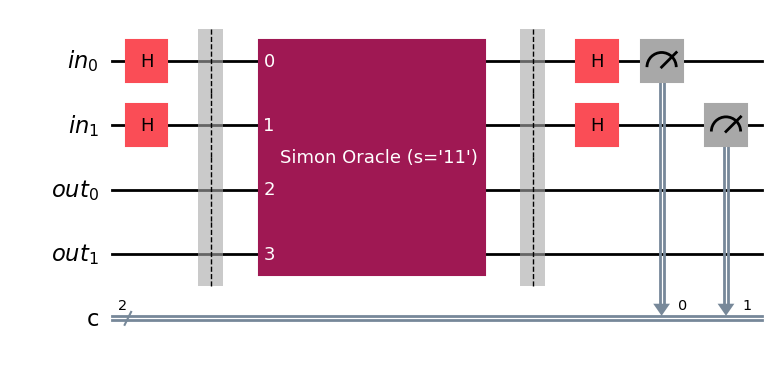


3. Parallelized Circuit:


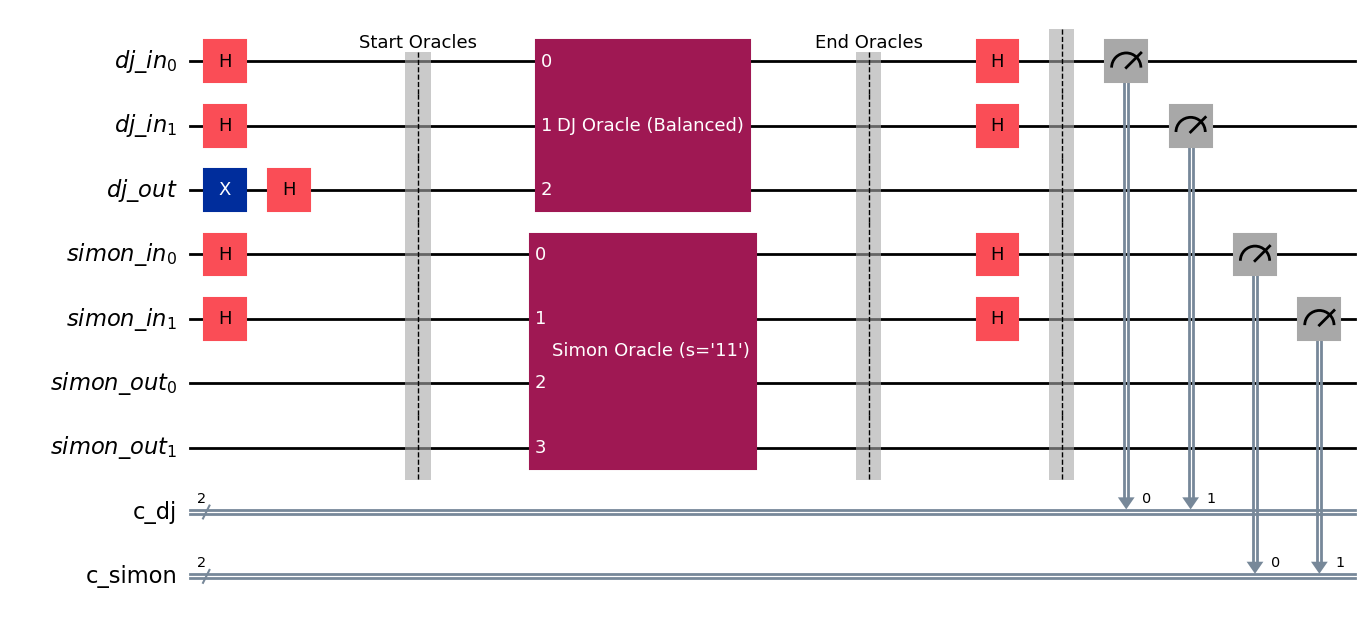


--- Circuit Depth Analysis ---
Depth of Sequential DJ Circuit: 5
Depth of Sequential Simon Circuit: 4
Sum of Sequential Depths: 9
Depth of Parallelized Circuit: 5

Theoretical Depth Reduction Achieved: 44.44%

--- Simulation Results ---
DJ Analysis: The oracle is balanced. We expect any outcome EXCEPT '00'.
Simon Analysis: For s='11', we expect outcomes y where y.s = 0 mod 2.
Possible outcomes: '00' and '11'.
Parallel Analysis: The combined output should match the individual results.


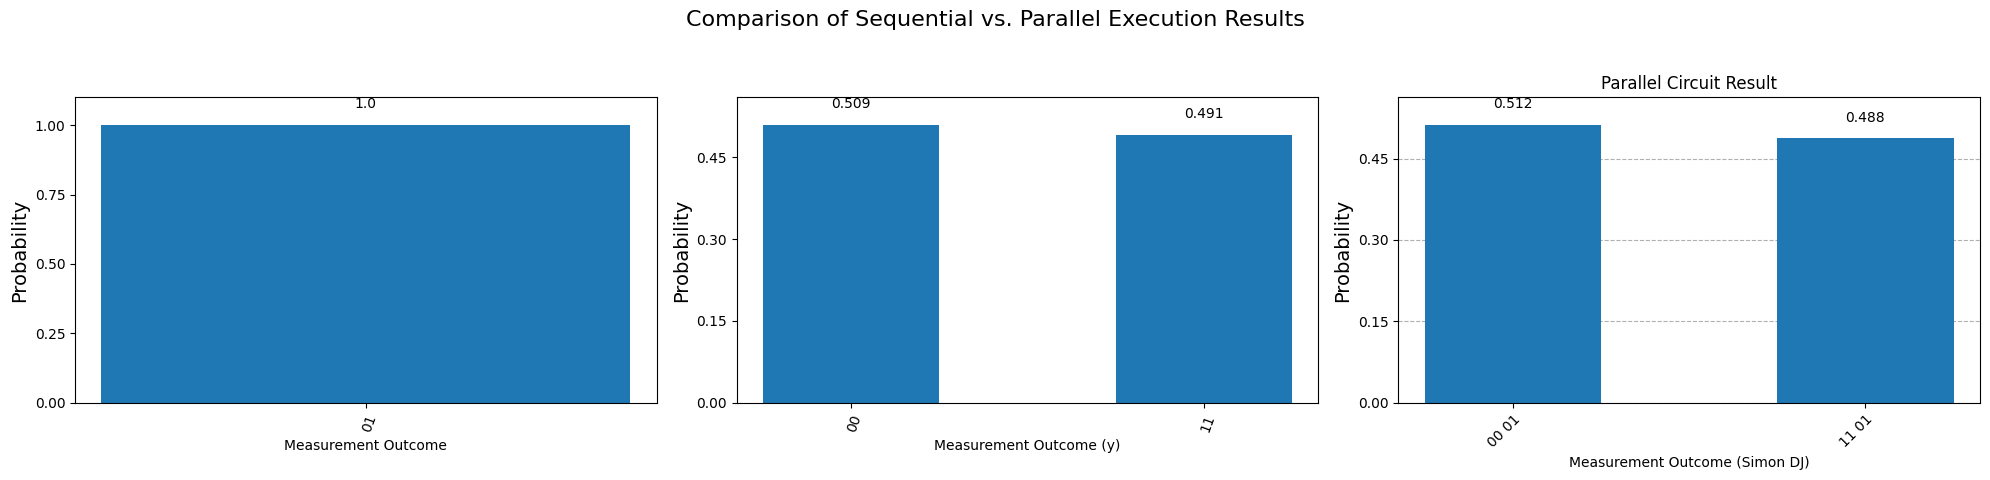

In [ ]:
# ==============================================================================
# 1. Install and import necessary libraries
# ==============================================================================

!pip install -q numpy qiskit qiskit-aer matplotlib pylatexenc

import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# ==============================================================================
# 2. ORACLE DEFINITIONS
# ==============================================================================
# These functions create the oracle components, which will be inserted into the
# main algorithm circuits.

def create_dj_oracle(input_register, output_register):
    """Creates a Deutsch-Jozsa oracle for a balanced function.

    For n inputs, this oracle implements a balanced function by applying a CNOT
    from the first input qubit to the output qubit. This makes the output
    dependent on one of the input bits, ensuring it's not constant.
    """
    qc = QuantumCircuit(input_register, output_register, name="DJ Oracle (Balanced)")
    qc.cx(input_register[0], output_register[0])
    return qc

def create_simon_oracle(input_register, output_register, secret_string):
    """Creates a Simon's algorithm oracle.

    This oracle implements a function f(x) that hides a secret string 's'
    such that f(x) = f(y) if and only if y = x ⊕ s.
    The implementation here is f(x) = x_0⊕x_1, x_0⊕x_1 for n=2 and s='11'.
    """
    n = input_register.size
    qc = QuantumCircuit(input_register, output_register, name=f"Simon Oracle (s='{secret_string}')")

    # This specific implementation creates a function that is 2-to-1
    # with the hidden period 's'. For s='11', f(x) = f(x ⊕ 11).
    for i in range(n):
        qc.cx(input_register[0], output_register[i])
        qc.cx(input_register[1], output_register[i])

    return qc

# ==============================================================================
# 3. FULL CIRCUIT CONSTRUCTION
# ==============================================================================
# These functions build the complete, runnable circuits for each algorithm.

def build_dj_circuit(n_dj):
    """Builds a standalone Deutsch-Jozsa circuit."""
    input_q = QuantumRegister(n_dj, name='in')
    output_q = QuantumRegister(1, name='out')
    c_reg = ClassicalRegister(n_dj, name='c')
    circuit = QuantumCircuit(input_q, output_q, c_reg)

    # 1. Create superposition on input and set ancilla to |->
    circuit.h(input_q)
    circuit.x(output_q)
    circuit.h(output_q)
    circuit.barrier()

    # 2. Apply the oracle
    dj_oracle = create_dj_oracle(input_q, output_q)
    circuit.append(dj_oracle, input_q[:] + output_q[:])
    circuit.barrier()

    # 3. Apply final Hadamards for interference
    circuit.h(input_q)

    # 4. Measure the input register
    circuit.measure(input_q, c_reg)
    return circuit

def build_simon_circuit(n_simon, secret_string):
    """Builds a standalone Simon's algorithm circuit."""
    input_q = QuantumRegister(n_simon, name='in')
    output_q = QuantumRegister(n_simon, name='out')
    c_reg = ClassicalRegister(n_simon, name='c')
    circuit = QuantumCircuit(input_q, output_q, c_reg)

    # 1. Create superposition on input register
    circuit.h(input_q)
    circuit.barrier()

    # 2. Apply the oracle
    simon_oracle = create_simon_oracle(input_q, output_q, secret_string)
    circuit.append(simon_oracle, input_q[:] + output_q[:])
    circuit.barrier()

    # 3. Apply final Hadamards for interference
    circuit.h(input_q)

    # 4. Measure the input register
    circuit.measure(input_q, c_reg)
    return circuit

def build_parallel_circuit(n_dj, n_simon, secret_string):
    """Builds a single circuit to run DJ and Simon's algorithms in parallel."""
    # Define separate registers for clarity
    dj_input_q = QuantumRegister(n_dj, name='dj_in')
    dj_output_q = QuantumRegister(1, name='dj_out')
    simon_input_q = QuantumRegister(n_simon, name='simon_in')
    simon_output_q = QuantumRegister(n_simon, name='simon_out')
    dj_c = ClassicalRegister(n_dj, name='c_dj')
    simon_c = ClassicalRegister(n_simon, name='c_simon')

    circuit = QuantumCircuit(dj_input_q, dj_output_q, simon_input_q, simon_output_q, dj_c, simon_c)

    # 1. Initial Superposition (Applied in parallel)
    circuit.h(dj_input_q)
    circuit.x(dj_output_q)
    circuit.h(dj_output_q)
    circuit.h(simon_input_q)
    circuit.barrier(label="Start Oracles")

    # 2. Apply Oracles (Applied in parallel on disjoint qubits)
    dj_oracle = create_dj_oracle(dj_input_q, dj_output_q)
    circuit.append(dj_oracle, dj_input_q[:] + dj_output_q[:])

    simon_oracle = create_simon_oracle(simon_input_q, simon_output_q, secret_string)
    circuit.append(simon_oracle, simon_input_q[:] + simon_output_q[:])
    circuit.barrier(label="End Oracles")

    # 3. Final Hadamards (Applied in parallel)
    circuit.h(dj_input_q)
    circuit.h(simon_input_q)
    circuit.barrier()

    # 4. Measurement
    circuit.measure(dj_input_q, dj_c)
    circuit.measure(simon_input_q, simon_c)

    return circuit

# ==============================================================================
# 4. ANALYSIS AND VISUALIZATION
# ==============================================================================

# --- Parameters ---
N_DJ = 2
N_SIMON = 2
SIMON_S = '11'

# --- Build the circuits ---
dj_circuit_seq = build_dj_circuit(N_DJ)
simon_circuit_seq = build_simon_circuit(N_SIMON, SIMON_S)
parallel_circuit = build_parallel_circuit(N_DJ, N_SIMON, SIMON_S)

# --- Visualize the circuits using Matplotlib ('mpl') drawer ---
print("--- Circuit Diagrams (Matplotlib Visualization) ---")

print("\n1. Deutsch-Jozsa Circuit (Sequential):")
display(dj_circuit_seq.draw('mpl', style='iqx'))

print("\n2. Simon's Algorithm Circuit (Sequential):")
display(simon_circuit_seq.draw('mpl', style='iqx'))

print("\n3. Parallelized Circuit:")
display(parallel_circuit.draw('mpl', style='iqx'))


# --- Circuit Depth Analysis ---
print("\n--- Circuit Depth Analysis ---")
depth_dj = dj_circuit_seq.depth()
depth_simon = simon_circuit_seq.depth()
depth_parallel = parallel_circuit.depth()

print(f"Depth of Sequential DJ Circuit: {depth_dj}")
print(f"Depth of Sequential Simon Circuit: {depth_simon}")
print(f"Sum of Sequential Depths: {depth_dj + depth_simon}")
print(f"Depth of Parallelized Circuit: {depth_parallel}")
print(f"\nTheoretical Depth Reduction Achieved: {((depth_dj + depth_simon) - depth_parallel) / (depth_dj + depth_simon):.2%}")


# ==============================================================================
# 5. SIMULATION
# ==============================================================================
sampler = Sampler()
shots = 2048

# Run sequential jobs
job_dj = sampler.run(dj_circuit_seq, shots=shots)
result_dj = job_dj.result()
counts_dj = result_dj.quasi_dists[0].binary_probabilities()

job_simon = sampler.run(simon_circuit_seq, shots=shots)
result_simon = job_simon.result()
counts_simon = result_simon.quasi_dists[0].binary_probabilities()

# Run parallel job
job_parallel = sampler.run(parallel_circuit, shots=shots)
result_parallel = job_parallel.result()
# The result keys are integers. We need to format them into binary strings.
# The format is "c_simon c_dj"
raw_counts_parallel = result_parallel.quasi_dists[0]
counts_parallel = {}
for outcome, prob in raw_counts_parallel.items():
    # Format the integer outcome into a binary string
    # Total classical bits = N_SIMON + N_DJ
    full_binary_str = format(outcome, f'0{N_SIMON + N_DJ}b')
    # Split the string according to the register sizes
    simon_bits = full_binary_str[:N_SIMON]
    dj_bits = full_binary_str[N_SIMON:]
    formatted_key = f"{simon_bits} {dj_bits}"
    counts_parallel[formatted_key] = prob

# ==============================================================================
# 6. RESULTS
# ==============================================================================
print("\n--- Simulation Results ---")

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Comparison of Sequential vs. Parallel Execution Results', fontsize=16)

# DJ Results
plot_histogram(counts_dj, ax=axs[0], title="Deutsch-Jozsa Result")
axs[0].set_xlabel("Measurement Outcome")
axs[0].set_ylabel("Probability")
print("DJ Analysis: The oracle is balanced. We expect any outcome EXCEPT '00'.")

# Simon Results
plot_histogram(counts_simon, ax=axs[1], title="Simon's Algorithm Result")
axs[1].set_xlabel("Measurement Outcome (y)")
axs[1].set_ylabel("Probability")
print(f"Simon Analysis: For s='{SIMON_S}', we expect outcomes y where y.s = 0 mod 2.")
print("Possible outcomes: '00' and '11'.")

# Parallel Results
plot_histogram(counts_parallel, ax=axs[2], title="Parallel Circuit Result")
axs[2].set_xlabel("Measurement Outcome (Simon DJ)")
axs[2].set_ylabel("Probability")
axs[2].tick_params(axis='x', rotation=45)
print("Parallel Analysis: The combined output should match the individual results.")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()